---
title: "How does Cam Ward stack up?"
description: "How does Cam Ward compare to this year's rookies and historical Titans QBs"
author: "chicken"
date: "12/26/2025"
categories:
    - "tennessee titans"
image: charts/epa_attempt_attempts_TEN.png
lightbox: true
draft: false
---

![](charts/epa_attempt_attempts_TEN.png)

## Housekeeping

### Import dependencies and set options

In [ ]:
# chickenstats library and utilities
from chickenstats.chicken_nhl._helpers import charts_directory

import nflreadpy as nfl

import polars as pl


# plotting library and utilities
import matplotlib.pyplot as plt
import seaborn as sns

# miscellaneous utilities
from pathlib import Path

In [ ]:
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(30)

polars.config.Config

### Create directory for charts

In [ ]:
charts_directory()

### chickenstats matplotlib styles

In [ ]:
plt.style.use("chickenstats")  # this is available when you import chickenstats.utilities

## Downloading and prepping data

### Player stats

In [ ]:
seasons = list(range(2002, 2026))

player_stats = nfl.load_player_stats(seasons=seasons)

In [ ]:
conditions = (pl.col("player_id") != "0", pl.col("player_name").is_not_null())

player_stats = player_stats.filter(conditions)

### Rosters

In [ ]:
rosters = nfl.load_rosters_weekly(seasons=seasons)

In [ ]:
rosters = rosters.filter(pl.col("status") == "ACT")

### Adding years of experience

In [ ]:
columns = (pl.col("season"), pl.col("gsis_id").alias("player_id"), pl.col("week"), pl.col("years_exp"))

merge_columns = ["season", "player_id", "week"]

player_stats = player_stats.join(rosters.select(columns), on=merge_columns)

### Aggregating to season level

In [ ]:
group_columns = [
    "player_id",
    "player_name",
    "player_display_name",
    "position",
    "position_group",
    "season",
    "season_type",
    "team",
    "years_exp",
]

group_columns = (pl.col(x) for x in group_columns)

sum_columns = [
    "completions",
    "attempts",
    "passing_yards",
    "passing_tds",
    "passing_interceptions",
    "sacks_suffered",
    "sack_yards_lost",
    "sack_fumbles",
    "sack_fumbles_lost",
    "passing_air_yards",
    "passing_yards_after_catch",
    "passing_first_downs",
    "passing_epa",
    "passing_2pt_conversions",
    "carries",
    "rushing_yards",
    "rushing_tds",
    "rushing_fumbles",
    "rushing_fumbles_lost",
    "rushing_first_downs",
    "rushing_epa",
    "rushing_2pt_conversions",
    "receptions",
    "targets",
    "receiving_yards",
    "receiving_tds",
    "receiving_fumbles",
    "receiving_fumbles_lost",
    "receiving_air_yards",
    "receiving_yards_after_catch",
    "receiving_first_downs",
    "receiving_epa",
    "receiving_2pt_conversions",
    "special_teams_tds",
    "def_tackles_solo",
    "def_tackles_with_assist",
    "def_tackle_assists",
    "def_tackles_for_loss",
    "def_tackles_for_loss_yards",
    "def_fumbles_forced",
    "def_sacks",
    "def_sack_yards",
    "def_qb_hits",
    "def_interceptions",
    "def_interception_yards",
    "def_pass_defended",
    "def_tds",
    "def_fumbles",
    "def_safeties",
    "misc_yards",
    "fumble_recovery_own",
    "fumble_recovery_yards_own",
    "fumble_recovery_opp",
    "fumble_recovery_yards_opp",
    "fumble_recovery_tds",
    "penalties",
    "penalty_yards",
    "punt_returns",
    "punt_return_yards",
    "kickoff_returns",
    "kickoff_return_yards",
    "fg_made",
    "fg_att",
    "fg_missed",
    "fg_blocked",
    "fg_long",
    "fg_made_0_19",
    "fg_made_20_29",
    "fg_made_30_39",
    "fg_made_40_49",
    "fg_made_50_59",
    "fg_made_60_",
    "fg_missed_0_19",
    "fg_missed_20_29",
    "fg_missed_30_39",
    "fg_missed_40_49",
    "fg_missed_50_59",
    "fg_missed_60_",
    "pat_made",
    "pat_att",
    "pat_missed",
    "pat_blocked",
    "pat_pct",
    "gwfg_made",
    "gwfg_att",
    "gwfg_missed",
    "gwfg_blocked",
    "gwfg_distance",
    "fantasy_points",
    "fantasy_points_ppr",
]

sum_columns = (pl.col(x).sum().alias(f"{x}_sum") for x in sum_columns)

mean_columns = ["passing_cpoe", "target_share", "air_yards_share", "pacr", "racr", "wopr"]

mean_columns = (pl.col(x).mean().alias(f"{x}_mean") for x in mean_columns)

agg_columns = (*sum_columns, *mean_columns)


player_stats = player_stats.group_by(group_columns).agg(agg_columns)

### Getting QB stats

In [ ]:
conditions = (
    pl.col("player_id") != "0",
    pl.col("player_name").is_not_null(),
    pl.col("position") == "QB",
    pl.col("attempts_sum") >= 1,
    pl.col("season_type") == "REG",
    pl.col("years_exp") == 0,
)

qb_stats = player_stats.filter(conditions)

In [ ]:
qb_stats = qb_stats.with_columns(epa_per_attempt=pl.col("passing_epa_sum") / pl.col("attempts_sum"))

## Plotting data

### Setting team and other values

In [ ]:
team = "TEN"
light_blue = "#4B92DB"
navy = "#002244"
red = "#C60C30"
gray = "#D3D3D3"

### Scatter plot

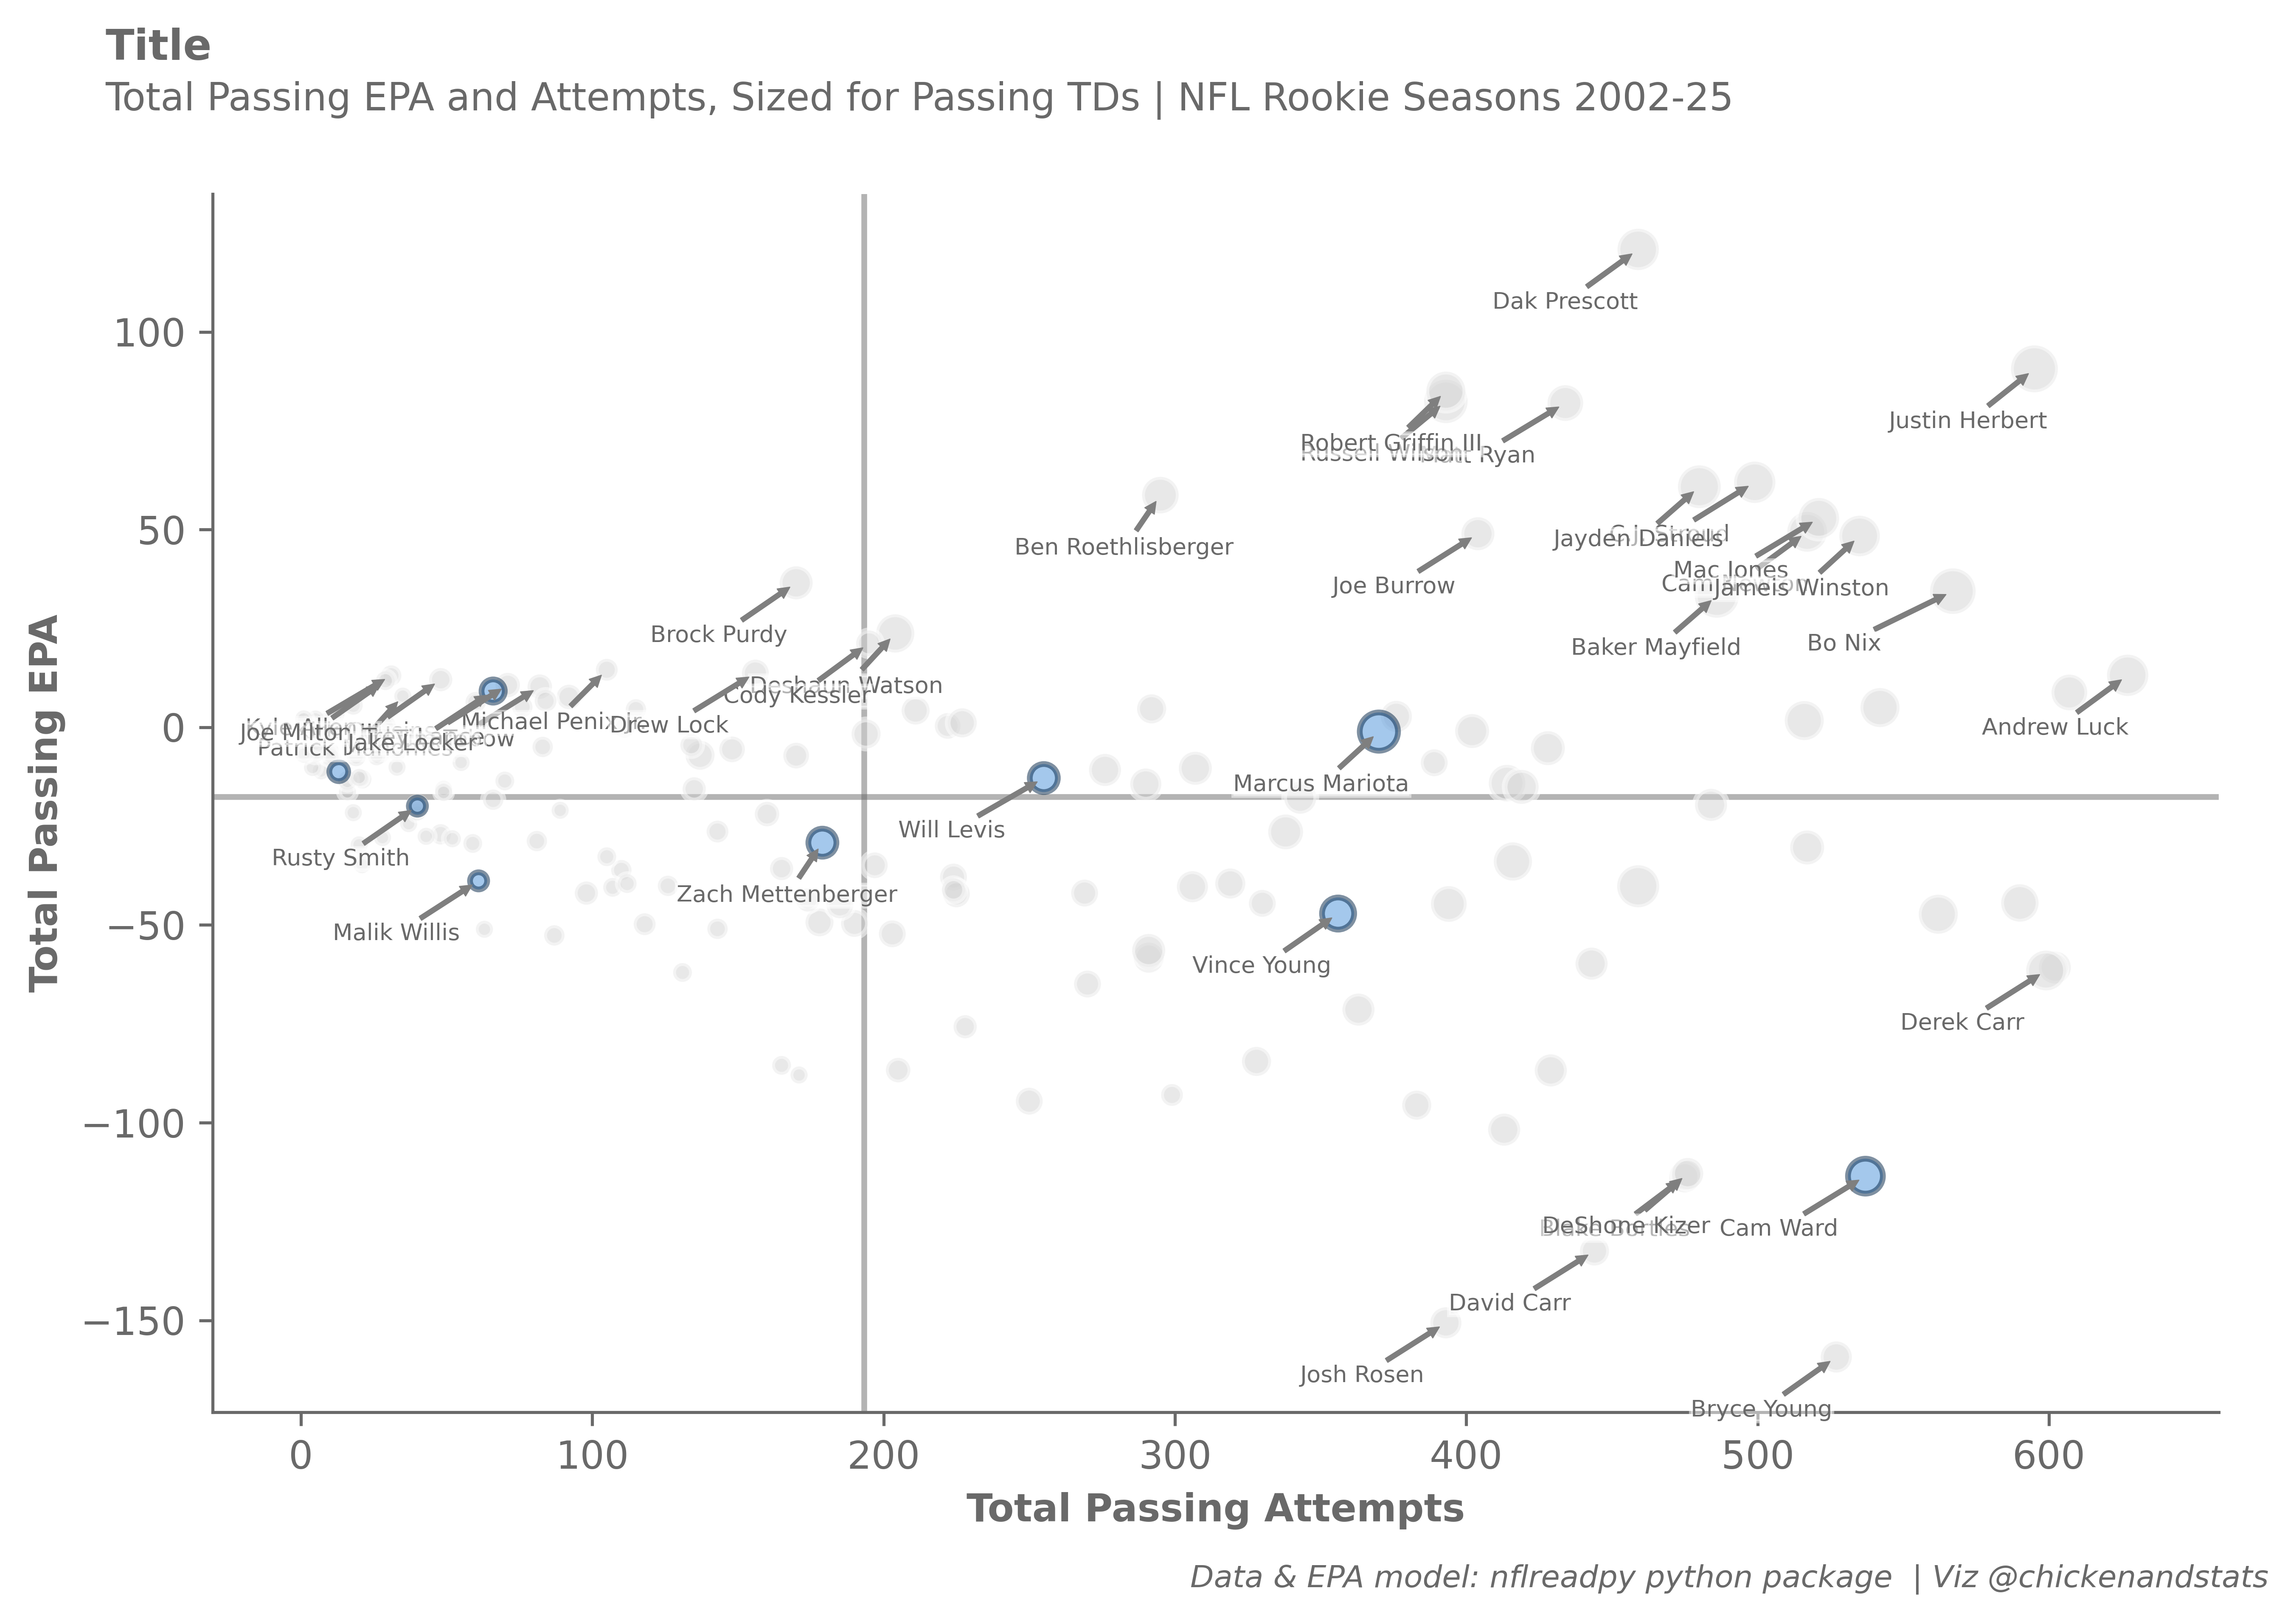

In [ ]:
# Setting overall figures
fig, ax = plt.subplots(dpi=650, figsize=(8, 5))

# Aesthetics, likes the tight layout and despining axes
fig.tight_layout()
sns.despine()

# Setting the x, y, and z values

x_col = "attempts_sum"
y_col = "passing_epa_sum"
size_col = "passing_tds_sum"

# Getting the averages and drawing the average lines
x_mean = qb_stats.select(pl.col(x_col)).mean().item(0, 0)
y_mean = qb_stats.select(pl.col(y_col)).mean().item(0, 0)

ax.axvline(x=x_mean, zorder=-1, alpha=0.5)
ax.axhline(y=y_mean, zorder=-1, alpha=0.5)

# Setting the size norm so bubbles are consistent across figures
size_min = qb_stats.select(pl.col(size_col)).min().item(0, 0)
size_max = qb_stats.select(pl.col(size_col)).max().item(0, 0)

size_norm = (size_min, size_max)
sizes = (20, 150)

# Filtering data and plotting the non-selected teams first
plot_data = qb_stats.filter(pl.col("team") != team)

# They all get gray colors
facecolor = gray
edgecolor = "white"

# Plotting the non-selected teams' data
sns.scatterplot(
    x=plot_data[x_col],
    y=plot_data[y_col],
    size=plot_data[size_col],
    sizes=sizes,
    size_norm=size_norm,
    lw=1.5,
    facecolor=facecolor,
    edgecolor=edgecolor,
    alpha=0.5,
    legend=False,
)

# Filtering the data and plotting the selected team
plot_data = qb_stats.filter(pl.col("team") == team)

# Setting the colors
facecolor = light_blue
edgecolor = navy

# Plotting the selected teams' data
sns.scatterplot(
    x=plot_data[x_col],
    y=plot_data[y_col],
    size=plot_data[size_col],
    sizes=sizes,
    size_norm=size_norm,
    lw=1.5,
    facecolor=facecolor,
    edgecolor=edgecolor,
    alpha=0.5,
    legend=False,
)

# Labeling Cam Ward

player_list = [
    "C.Ward",
    "P.Mahomes",
    "R.Wilson",
    "J.Burrow",
    "D.Prescott",
    "J.Herbert",
    "R.Griffin",
    "M.Ryan",
    "C.Stroud",
    "J.Daniels",
    "B.Roethlisberger",
    "M.Jones",
    "C.Newton",
    "J.Burrow",
    "J.Winston",
    "B.Purdy",
    "B.Nix",
    "B.Mayfield",
    "D.Watson",
    "C.Kessler",
    "M.Penix",
    "D.Lock",
    "A.Luck",
    "K.Allen",
    "K.Cousins",
    "J.Milton",
    "T.Lance",
    "T.Tebow",
    "J.Locker",
    "M.Mariota",
    "W.Levis",
    "R.Smith",
    "Z.Mettenberger",
    "M.Willis",
    "V.Young",
    "B.Young",
    "J.Rosen",
    "D.Carr",
    "B.Bortles",
    "D.Kizer",
]

label_data = qb_stats.filter(pl.col("player_name").is_in(player_list), pl.col("years_exp") == 0)

x_offset = -50
y_offset = -15

for player_data in label_data.iter_rows(named=True):
    x_position = player_data[x_col] + x_offset
    y_position = player_data[y_col] + y_offset

    arrow_props = {"arrowstyle": "simple", "linewidth": 0.25, "color": "tab:gray"}

    # Plotting the annotation
    ax.annotate(
        text=f"{player_data['player_display_name']}",
        xy=(player_data[x_col], player_data[y_col]),
        xytext=(x_position, y_position),
        fontsize=6,
        bbox={"facecolor": "white", "alpha": 0.5, "edgecolor": "white", "pad": 0},
        arrowprops=arrow_props,
    )

# Iterating through the dataframe to label the bubbles
# for row, player in plot_data.iterrows():
#     # Setting x and y positions that are slightly offset from the data they point to
#     x_position = player.xga_p60 + 0.25
#     y_position = player.xgf_p60 - 0.25

#     # Annotation options
#     arrow_props = {"arrowstyle": "simple", "linewidth": 0.25, "color": "tab:gray"}

#     # Plotting the annotation
#     ax.annotate(
#         text=f"{player.player}",
#         xy=(player.xga_p60, player.xgf_p60),
#         xytext=(x_position, y_position),
#         fontsize=6,
#         bbox={"facecolor": "white", "alpha": 0.5, "edgecolor": "white", "pad": 0},
#         arrowprops=arrow_props,
#     )

# Setting axis lables
ax.axes.set_xlabel("Total Passing Attempts")
ax.axes.set_ylabel("Total Passing EPA")

# Setting figure suptitle and subtitle
fig_suptitle = "Title"
fig.suptitle(fig_suptitle, x=0.01, y=1.08, fontsize=11, fontweight="bold", horizontalalignment="left")

subtitle = "Total Passing EPA and Attempts, Sized for Passing TDs | NFL Rookie Seasons 2002-25"
fig.text(s=subtitle, x=0.01, y=1.02, fontsize=10, horizontalalignment="left")

# Attribution
attribution = "Data & EPA model: nflreadpy python package  | Viz @chickenandstats"
fig.text(s=attribution, x=0.99, y=-0.05, fontsize=8, horizontalalignment="right", style="italic")

# Save figure
savepath = Path(f"./charts/epa_attempt_attempts_{team}.png")
# fig.savefig(savepath, transparent=False, bbox_inches="tight")

In [ ]:
qb_stats.filter(pl.col("player_name").str.contains("V.Young"))
# qb_stats.sort("passing_epa_sum", descending=True).head(25)["player_name"].unique().to_list()
qb_stats.filter(pl.col("years_exp") == 0).sort("passing_epa_sum", descending=True).tail(25)

player_id,player_name,player_display_name,position,position_group,season,season_type,team,years_exp,completions_sum,attempts_sum,passing_yards_sum,passing_tds_sum,passing_interceptions_sum,sacks_suffered_sum,sack_yards_lost_sum,sack_fumbles_sum,sack_fumbles_lost_sum,passing_air_yards_sum,passing_yards_after_catch_sum,passing_first_downs_sum,passing_epa_sum,passing_2pt_conversions_sum,carries_sum,rushing_yards_sum,rushing_tds_sum,rushing_fumbles_sum,rushing_fumbles_lost_sum,rushing_first_downs_sum,rushing_epa_sum,rushing_2pt_conversions_sum,receptions_sum,targets_sum,receiving_yards_sum,receiving_tds_sum,receiving_fumbles_sum,receiving_fumbles_lost_sum,receiving_air_yards_sum,receiving_yards_after_catch_sum,receiving_first_downs_sum,receiving_epa_sum,receiving_2pt_conversions_sum,special_teams_tds_sum,def_tackles_solo_sum,def_tackles_with_assist_sum,def_tackle_assists_sum,def_tackles_for_loss_sum,def_tackles_for_loss_yards_sum,def_fumbles_forced_sum,def_sacks_sum,def_sack_yards_sum,def_qb_hits_sum,def_interceptions_sum,def_interception_yards_sum,def_pass_defended_sum,def_tds_sum,def_fumbles_sum,def_safeties_sum,misc_yards_sum,fumble_recovery_own_sum,fumble_recovery_yards_own_sum,fumble_recovery_opp_sum,fumble_recovery_yards_opp_sum,fumble_recovery_tds_sum,penalties_sum,penalty_yards_sum,punt_returns_sum,punt_return_yards_sum,kickoff_returns_sum,kickoff_return_yards_sum,fg_made_sum,fg_att_sum,fg_missed_sum,fg_blocked_sum,fg_long_sum,fg_made_0_19_sum,fg_made_20_29_sum,fg_made_30_39_sum,fg_made_40_49_sum,fg_made_50_59_sum,fg_made_60__sum,fg_missed_0_19_sum,fg_missed_20_29_sum,fg_missed_30_39_sum,fg_missed_40_49_sum,fg_missed_50_59_sum,fg_missed_60__sum,pat_made_sum,pat_att_sum,pat_missed_sum,pat_blocked_sum,pat_pct_sum,gwfg_made_sum,gwfg_att_sum,gwfg_missed_sum,gwfg_blocked_sum,gwfg_distance_sum,fantasy_points_sum,fantasy_points_ppr_sum,passing_cpoe_mean,target_share_mean,air_yards_share_mean,pacr_mean,racr_mean,wopr_mean,epa_per_attempt
str,str,str,str,str,i32,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,i32,i32,i32,i32,i32,i32,i32,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""00-0035652""","""R.Finley""","""Ryan Finley""","""QB""","""QB""",2019,"""REG""","""CIN""",0,41,87,474,2,2,11,-93,4,3,721,203,20,-52.636759,0,10,77,0,0,0,5,0.280104,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,24.66,24.66,-15.687838,0.0,0.0,0.65507,null,0.0,-0.60502
"""00-0027950""","""C.Ponder""","""Christian Ponder""","""QB""","""QB""",2011,"""REG""","""MIN""",0,158,291,1853,13,13,30,-164,5,2,2667,831,91,-56.446926,0,28,219,0,1,0,15,17.573881,0,0,0,0,0,0,0,0,0,0,0.0,0,0,2,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,118.02,118.02,-7.464352,0.0,0.0,0.691941,null,0.0,-0.193976
"""00-0026993""","""J.Freeman""","""Josh Freeman""","""QB""","""QB""",2009,"""REG""","""TB""",0,159,291,1857,10,18,19,-102,5,1,2649,658,89,-58.254535,1,31,162,0,4,1,15,2.430892,1,0,0,1,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,5,7,0,0,0,3,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,94.58,94.58,-4.683177,0.0,0.0,0.733723,0.0,0.0,-0.200187
"""00-0030565""","""G.Smith""","""Geno Smith""","""QB""","""QB""",2013,"""REG""","""NYJ""",0,247,443,3046,12,21,43,-315,4,3,3963,1260,143,-59.77581,0,72,366,6,4,1,28,14.142214,0,1,1,13,0,0,0,13,0,1,1.309993,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,3,4,0,0,0,5,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,193.74,194.74,-4.97212,0.002604,0.002871,0.874442,1.0,0.005916,-0.134934
"""00-0036971""","""T.Lawrence""","""Trevor Lawrence""","""QB""","""QB""",2021,""

In [ ]:
qb_stats["season"].unique().to_list()

[2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024,
 2025]